In [4]:
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
import HodaDatasetReader.HodaDatasetReader as HodaDatasetReader
import pickle

%matplotlib inline

# Question No.2

In [5]:
train_images, train_labels = HodaDatasetReader.read_hoda_cdb("./HodaDatasetReader/DigitDB/Train 60000.cdb")
test_images, test_labels = HodaDatasetReader.read_hoda_cdb('./HodaDatasetReader/DigitDB/Test 20000.cdb')

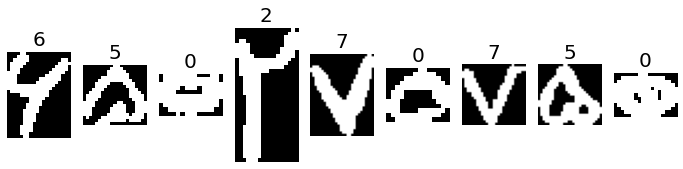

In [31]:
plt.figure(figsize=(12,3))
for i in range(9):
    plt.subplot(1,9,i+1), plt.imshow(train_images[i], 'gray')
    plt.axis('off'), plt.title(train_labels[i], size=20)
    
plt.show()

## resizing all images to 32 * 32

In [6]:
resize = lambda img: cv2.resize(img, (32,32))

train_images = list(map(resize ,train_images))
test_images = list(map(resize ,test_images))

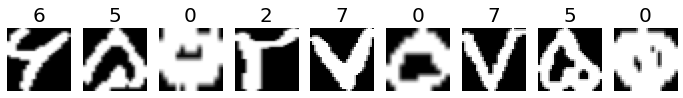

In [67]:
plt.figure(figsize=(12,3))
for i in range(9):
    plt.subplot(1,9,i+1), plt.imshow(train_images[i], 'gray')
    plt.axis('off'), plt.title(train_labels[i], size=20)
    
plt.show()

## HOG

In [105]:
%time
hog_ = lambda img: hog(img, orientations=8, pixels_per_cell=(4, 4),cells_per_block=(1, 1), visualize=True)[1]

train_images_HOG = list(map(hog_ ,train_images))
test_images_HOG = list(map(hog_ ,test_images))

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 16.5 µs


In [107]:
with open("train_images_HOG", '+wb') as file:
    pickle.dump(train_images_HOG, file)
    
with open("test_images_HOG", '+wb') as file:
    pickle.dump(test_images_HOG, file)

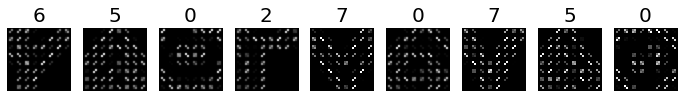

In [106]:
plt.figure(figsize=(12,3))
for i in range(9):
    plt.subplot(1,9,i+1), plt.imshow(train_images_HOG[i], 'gray')
    plt.axis('off'), plt.title(train_labels[i], size=20)
    
plt.show()

## LBP

In [95]:
from skimage.feature import local_binary_pattern

lbp_ = lambda img: local_binary_pattern(img, 8, 1, method="uniform")

train_images_LBP = list(map(lbp_ ,train_images))
test_images_LBP = list(map(lbp_ ,test_images))

In [96]:
with open("train_images_LBP", '+wb') as file:
    pickle.dump(train_images_LBP, file)
    
with open("test_images_LBP", '+wb') as file:
    pickle.dump(test_images_LBP, file)

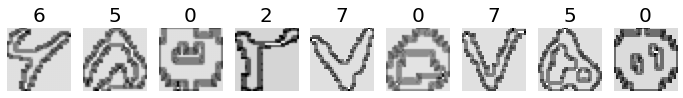

In [104]:
plt.figure(figsize=(12,3))
for i in range(9):
    plt.subplot(1,9,i+1), plt.imshow(train_images_LBP[i], 'gray')
    plt.axis('off'), plt.title(train_labels[i], size=20)
    
plt.show()

## My LBP

In [90]:
def lbp(img, y, x):
    value_ = np.array([2**n for n in range(8)][::-1])
    # [128, 64, 32, 16, 8, 4, 2, 1]
    lbp_ = np.zeros(8, dtype=int)
    
    center = img[y, x]
    
    y_index = [y - 1, y - 1, y - 1, y, y, y + 1, y + 1, y + 1] 
    x_index = [x - 1, x, x + 1, x - 1, x + 1, x - 1, x, x + 1]
    
    for i, (y, x) in enumerate(list(zip(y_index, x_index))):
        if img[y, x] >= center:
            lbp_[i] = 1
    return (lbp_ * value_).sum()

In [91]:
def my_lbf(img):
    height, width = img.shape

    padded_img = np.zeros((height + 2, width + 2))
    padded_img[1:-1, 1:-1] = img.copy()
    
    lbp_ = np.zeros_like(img)
    
    for y in range(1, height + 1):
        for x in range(1, width + 1):
            lbp_[y-1, x-1] = lbp(padded_img, y, x)
    return lbp_

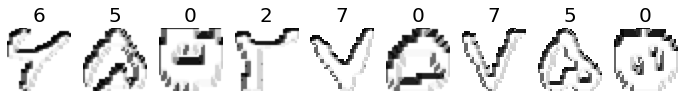

In [92]:
plt.figure(figsize=(12,3))
for i in range(9):
    plt.subplot(1,9,i+1), plt.imshow(my_lbf(train_images[i]), 'gray')
    plt.axis('off'), plt.title(train_labels[i], size=20)
    
plt.show()

In [93]:
%%time
my_lbp_ = lambda img: my_lbf(img)

train_images_my_LBP = list(map(my_lbp_ ,train_images))
test_images_my_LBP = list(map(my_lbp_ ,test_images))

CPU times: user 15min 55s, sys: 63.8 ms, total: 15min 56s
Wall time: 15min 56s


In [94]:
with open("train_images_my_LBP", '+wb') as file:
    pickle.dump(train_images_my_LBP, file)
    
with open("test_images_my_LBP", '+wb') as file:
    pickle.dump(test_images_my_LBP, file)

In [62]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score

In [81]:
%%time
svc = SVC()

svc.fit(np.array(train_images_my_LBP).reshape(60000,1024), train_labels)

ValueError: cannot reshape array of size 20480000 into shape (60000,1024)

In [84]:
y_pred = svc.predict(np.array(test_images_my_LBP).reshape(20000,1024))

In [85]:
confusion_matrix(test_labels, y_pred)

array([[1967,   13,    1,    0,    0,   14,    2,    3,    0,    0],
       [   5, 1984,    1,    0,    4,    1,    2,    1,    0,    2],
       [   0,   10, 1936,   29,   13,    0,    5,    2,    0,    5],
       [   0,    1,  127, 1830,   37,    1,    2,    1,    1,    0],
       [   0,    6,   16,   35, 1933,    4,    1,    1,    0,    4],
       [  13,   11,    2,    0,    6, 1963,    1,    0,    3,    1],
       [   1,    6,    3,    3,    5,    9, 1932,    4,    0,   37],
       [   1,    5,   11,    0,    3,    0,   12, 1967,    0,    1],
       [   0,    3,    1,    0,    4,    0,    0,    0, 1981,   11],
       [   1,   11,    1,    0,    0,    2,   37,    0,    5, 1943]])

# Question 4

In [2]:
import tensorflow as tf
from tensorflow import keras

In [8]:
num_classes = len(np.unique(train_labels))

x_train = np.float32(train_images)/255
x_test = np.float32(test_images)/255

y_train = keras.utils.to_categorical(train_labels, num_classes=num_classes)
y_test = keras.utils.to_categorical(test_labels, num_classes=num_classes)

In [44]:
x_train = x_train.reshape(60000,32,32,1)
x_test = x_test.reshape(20000,32,32,1)

In [45]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, MaxPooling2D

model = keras.Sequential(name="Hoda_classifier")
model.add(keras.layers.Input(shape=(32,32,1)))

model.add(Conv2D(32, (3,3), padding="valid", activation='relu'))
model.add(Conv2D(32, (3,3), padding="valid", activation='relu'))

model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), padding="valid", activation='relu'))
model.add(Conv2D(64, (3,3), padding="valid", activation='relu'))

model.add(MaxPooling2D())

model.add(Conv2D(128, (3,3), padding="valid", activation='relu'))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=100, epochs=50)

Model: "Hoda_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 3, 3, 128)     

In [46]:
model.save('./model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./model/assets


In [49]:
from sklearn.metrics import confusion_matrix, accuracy_score
batch_size = 100

Y_pred = model.predict(x_test,  len(x_test)// batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))

Confusion Matrix
[[1977    1    1    0    0   20    0    1    0    0]
 [   3 1993    0    0    1    1    1    0    0    1]
 [   0    4 1980    8    6    0    0    0    0    2]
 [   0    0   22 1966    8    3    0    0    1    0]
 [   0    0    3   10 1984    1    1    0    1    0]
 [   6    0    1    0    1 1989    0    0    2    1]
 [   0    2    1    0    0    5 1981    0    1   10]
 [   5    5    1    2    2    0    3 1982    0    0]
 [   0    0    0    0    0    3    0    0 1995    2]
 [   1    3    0    0    4    2    4    0    0 1986]]


In [50]:
print(accuracy_score(test_labels, y_pred))

0.99165
